# **Classificação Temática de Postagens do Reddit**

O objetivo desse trabalho é a partir de um modelo de classifição realizar uma análise temática de publições feitas no Reddit.

# **1 - Base de dados**

A primeira etapa para o desenvovimento do projeto consiste em importar as bibliotecas necessarias para a análise e agrupamentos dos dados, destacando a biblioteca PRAW que permite a interação com a API do Reddit de maneira fácil.

In [ ]:
!pip install praw
!pip install torch transformers
!pip install emoji
!pip install spacy
!pip install numpy==1.24.4 catboost==1.2.2
!pip install lightgbm

import praw  # Biblioteca para acessar a API do Reddit e coletar dados de postagens, usuários e comentários.
import json  # Biblioteca para manipulação de dados no formato JSON, comum para APIs e arquivos estruturados.
import nltk  # Biblioteca para processamento de linguagem natural (PLN), incluindo tokenização e análise de sentimentos.
import pandas as pd  # Biblioteca para manipulação e análise de dados estruturados em DataFrames.
import numpy as np  # Biblioteca para operações matemáticas e manipulação eficiente de arrays multidimensionais.
import string  # Biblioteca para manipulação de strings, como remoção de pontuações.
import threading  # Biblioteca para executar múltiplas tarefas simultaneamente usando threads.
import torch  # Biblioteca para computação em machine learning e deep learning, usada principalmente com PyTorch.
import re # Biblioteca para importar as expressoes regulares
import emoji # Biblioteca para listar os emojis
import spacy # Biblioteca necessaria para utilizar o REN
import unicodedata
import matplotlib.pyplot as plt # Biblioteca utilizar para gerar gráficos
from sklearn.model_selection import train_test_split  # Biblioteca para dividir os dados em conjuntos de treino e teste.
from sklearn.feature_extraction.text import TfidfVectorizer  # Biblioteca para transformar texto em representações numéricas usando TF-IDF.
from sklearn.naive_bayes import MultinomialNB  # Biblioteca para classificação de textos usando o modelo Naive Bayes.
from sklearn.metrics import classification_report  # Biblioteca para gerar métricas de desempenho da classificação.
from nltk.corpus import stopwords  # Biblioteca que contém listas de palavras irrelevantes para PLN (stopwords).
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud  # Biblioteca para gerar nuvens de palavras a partir de textos.
from collections import Counter  # Biblioteca para contar a frequência de elementos em listas ou iteráveis.
from collections import defaultdict  # Biblioteca para criar dicionários com valores padrão dinâmicos.
from nltk.sentiment import SentimentIntensityAnalyzer  # Biblioteca para análise de sentimentos baseada no modelo VADER.
from concurrent.futures import ThreadPoolExecutor  # Biblioteca para paralelizar tarefas usando múltiplas threads.
from transformers import AutoTokenizer, AutoModelForSequenceClassification  # Biblioteca para carregar modelos pré-treinados de NLP, como LM-RoBERTa.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, auc
from tqdm import tqdm
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

print("Bibliotecas carregadas")


Bibliotecas carregadas


Logo em seguida vamos configurar a API do Reddit via PRAW.

In [ ]:
from google.colab import userdata
client_id = userdata.get("reddit_client_id")
assert client_id is not None
client_secret = userdata.get("reddit_client_secret")
assert client_secret is not None
app_name = userdata.get("reddit_app")
reddit = praw.Reddit(client_id=client_id,
                     client_secret=client_secret,
                     user_agent=app_name)
print("API linkada")

API linkada


Com a API configurada já é possível fazer extração de publicações desejadas. O objetivo modelo será classificar publicações dentre as seguintes temáticas:

*   **Política**
*   **Economia**
*   **Religião**
*   **Entretenimento**

Para isso vou utilizar de subreddits (comunidades dentro da plataforma) nichadas, ou seja, que são especificas para discurssão dos temas escolhidos, onde serão retiradas 1000 publicações de cada comunidade a fim de treinar o nosso modelo.


In [ ]:
# Definir os subreddits por tema
subreddits = {
    "politica": ["brasilivre", "brasildob"],
    "economia": ["investimentos", "empreendedorismo"],
    "religiao": ["espiritismo", "ateismo_br",],
    "entretenimento": ["filmeseseries", "MusicaBR"]
}

# Função para coletar postagens de um subreddit
def coletar_postagens(subreddit_nome, limite=1000):
    postagens = []
    subreddit = reddit.subreddit(subreddit_nome)

    for submission in subreddit.new(limit=limite):
        postagens.append({
            'titulo': submission.title,
            'corpo': submission.selftext,
            'upvotes': submission.ups,
            'data_criacao': submission.created_utc,
            'url': submission.url
        })

    return postagens

# Coletar e armazenar dados em um dataframe
dados = []

for tema, lista_subreddits in subreddits.items():
    print(f"Coletando postagens de {tema}...")
    for nome_subreddit in lista_subreddits:
        postagens = coletar_postagens(nome_subreddit)
        for postagem in postagens:
            postagem['tema'] = tema
        dados.extend(postagens)

# Converter os dados para um DataFrame
df = pd.DataFrame(dados)

# Salvar os dados em um arquivo CSV
df.to_csv('postagens_reddit.csv', index=False)

print("Coleta concluída e salva em 'postagens_reddit.csv'")


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.



Coletando postagens de politica...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coletando postagens de economia...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coletando postagens de religiao...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coletando postagens de entretenimento...


It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/latest/getting_started/multiple_instances.html#discord-bots-and-asynchronous-environments for more info.

It is strongly recommended to use Async PRAW: https://asyncpraw.readthedocs.io.
See https://praw.readthedocs.io/en/l

Coleta concluída e salva em 'postagens_reddit.csv'


# **1 - EDA**

In [ ]:
Amostra = pd.read_csv('postagens_reddit.csv')
Amostra.head()

,titulo,corpo,upvotes,data_criacao,url,tema
0,Se a gente taxar os ricos os negócio fica caro...,NaN,1,1.743106e+09,https://i.redd.it/6uwhhzpmhare1.jpeg,politica
1,so o meu reddit que ta caindo? ta dando erro h...,NaN,1,1.743105e+09,https://v.redd.it/22jvfkkidare1,politica
2,😂👆,NaN,6,1.743104e+09,https://i.redd.it/ldajltcraare1.png,politica
3,PCO sendo mais sensato do que muitos que se di...,NaN,10,1.743103e+09,https://i.redd.it/9w89qnf18are1.png,politica
4,Entenda como isso é bom para você! (G1),NaN,4,1.743102e+09,https://i.redd.it/agkciqyb5are1.png,politica


In [ ]:
Amostra.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7803 entries, 0 to 7802
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   titulo        7803 non-null   object 
 1   corpo         5100 non-null   object 
 2   upvotes       7803 non-null   int64  
 3   data_criacao  7803 non-null   float64
 4   url           7803 non-null   object 
 5   tema          7803 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage: 365.9+ KB


Podemos observar que a unica feature que possue valores nulos seria "Corpo", o corpo da publicação seria o local onde o usuário pode acrescentar uma imagem, vídeo ou até mesmo criar uma publicação mais extensa. Por esses motivos não necessariamente devemos tratar os valores nulos que esse feature possue.

Vamos fazer uma checagem rápida para explorar se existem duplicatas no dataset Amostra

In [ ]:
def checar_duplicadas(df):
    # Verifica linhas duplicadas
    duplicadas = df[df.duplicated()]

    if duplicadas.empty:
        print("✅ Nenhuma linha duplicada encontrada.")
    else:
        print(f"⚠️ Foram encontradas {duplicadas.shape[0]} linhas duplicadas:")
        print(duplicadas)

In [ ]:
checar_duplicadas(Amostra)

✅ Nenhuma linha duplicada encontrada.


Vamos alterar os valores dos temas de categoricos para númericos para garantir a utilização de alguns modelos e melhorar a perfomance também.

*   **Política** = 0
*   **Economia** = 1
*   **Religião** = 2
*   **Entretenimento** = 3


In [ ]:
valores_nulos = Amostra.isnull().sum()
valores_nulos

,0
titulo,0
corpo,2703
upvotes,0
data_criacao,0
url,0
tema,0


# **2 - Pré-processamento**

Para conseguir fazer uma melhor analíse sobre os dados obtidos, apliquei filtros sobre os textos que irão melhorar a perfomance dos algoritmos, entre eles foram retirados URLS, emojis, stopwords, etc...

In [ ]:
import pandas as pd
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji

# Baixar recursos necessários do NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Para suporte a idiomas diferentes em WordNet

# Carregar stopwords para o idioma português
stopwords_pt = set(stopwords.words('portuguese'))

# Inicializar o lematizador
lemmatizer = WordNetLemmatizer()

# Função para limpar o texto
def limpar_texto(texto):
    if isinstance(texto, float):  # Evitar erro se houver valores NaN
        return ""

    texto = texto.lower()  # Converter para minúsculas
    texto = re.sub(r"http[s]?://\S+", "", texto)  # Remover URLs
    texto = re.sub(r"@\w+", "", texto)  # Remover menções
    texto = re.sub(r"#\w+", "", texto)  # Remover hashtags
    texto = re.sub(r"^>.*", "", texto, flags=re.MULTILINE)  # Remover citações
    texto = re.sub(r"\b\d{1,2}[/.-]\d{1,2}[/.-]\d{2,4}\b", "", texto)  # Remover datas
    texto = emoji.replace_emoji(texto, replace="")  # Remover emojis
    texto = re.sub(r"\b(kkk+|hahaha+|rsrs+|hehe+)\b", "", texto)  # Remover risadas
    texto = re.sub(r"[\W_]+", " ", texto)  # Remover pontuação
    texto = re.sub(r"\d+", "", texto)  # **Remover números**

    # Remover acentos
    texto = ''.join(c for c in unicodedata.normalize('NFKD', texto) if not unicodedata.combining(c))

    # Remover stopwords
    texto = " ".join([palavra for palavra in texto.split() if palavra not in stopwords_pt])

    return texto.strip()

# Função de lematização com NLTK
def lematizar_texto(texto):
    if not texto:  # Verificar se o texto é vazio
        return ""
    return " ".join([lemmatizer.lemmatize(palavra) for palavra in texto.split()])

# Limpeza e lematização
# Carregar o dataset original
Amostra = pd.read_csv("postagens_reddit.csv")

# Verificar se as colunas existem e não possuem valores nulos
Amostra = Amostra.dropna(subset=['titulo', 'corpo'])

# Garantir que as colunas 'titulo' e 'corpo' sejam strings e aplicar limpeza e lematização
Amostra['titulo'] = Amostra['titulo'].fillna('').astype(str).apply(limpar_texto).apply(lematizar_texto)
Amostra['corpo'] = Amostra['corpo'].fillna('').astype(str).apply(limpar_texto).apply(lematizar_texto)

# Salvar dataset atualizado
Amostra.to_csv("postagens_reddit_limpo.csv", index=False)

print("Processamento concluído! Dados salvos em 'postagens_reddit_limpo.csv'.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Processamento concluído! Dados salvos em 'postagens_reddit_limpo.csv'.


In [ ]:
amostra_final = pd.read_csv('postagens_reddit_limpo.csv')
amostra_final.head()

,titulo,corpo,upvotes,data_criacao,url,tema
0,panico fabricado cerceamento liberdade,tempo tempo algum caso utilizado tentarem cerc...,3,1.743100e+09,https://i.redd.it/jawsvwgp0are1.jpeg,politica
1,desisti morar argentina realidade,pra argentina faz dez dia parei varias cidades...,5,1.743095e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica
2,argentina governo milei anuncia acordo u bilho...,NaN,7,1.743094e+09,https://www.metropoles.com/negocios/argentina-...,politica
3,esquerda hipocrisia,esquerda falando moral bandido pregando justic...,69,1.743089e+09,https://i.redd.it/vs6b773d29re1.jpeg,politica
4,alguma prova material bozo orquestrou gopi,porra desculpa fazer vcs ai google trampo ta f...,6,1.743074e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

amostra_final['tema'] = le.fit_transform(amostra_final['tema'])

In [ ]:
import numpy as np

unique_tema_values = np.unique(amostra_final['tema'])
print(unique_tema_values)

[0 1 2 3]


## TF-IDF (Term Frequency - Inverse Document Frequency)

Mede a frequência de uma palavra no texto e ajusta com base em quantos documentos essa palavra aparece.

In [ ]:
amostra_tdf = amostra_final.copy()

# Verificar se as colunas existem e não possuem valores nulos
amostra_tdf = amostra_tdf.dropna(subset=['titulo', 'corpo'])

# Criar um novo campo combinando título e corpo
# Instead of just adding, join with a space to avoid combining words
amostra_tdf["texto_completo"] = amostra_tdf.apply(lambda row: ' '.join([str(row['titulo']), str(row['corpo'])]), axis=1)

# Inicializar o vetor TF-IDF
# Remove stop words parameter and add token pattern
vectorizer = TfidfVectorizer(max_features=500, token_pattern=r"(?u)\b\w\w+\b")  # Limita para 500 palavras mais importantes, token pattern to include words with at least 2 characters

X_tfidf = vectorizer.fit_transform(amostra_tdf["texto_completo"])

# Antes de adicionar as novas features ao dataset original
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

# Garantir que os nomes das novas colunas sejam únicos
df_tfidf.columns = [f"tfidf_{col}" for col in df_tfidf.columns]

# Concatenar com o DataFrame original
amostra_final = pd.concat([amostra_tdf.reset_index(drop=True), df_tfidf.reset_index(drop=True)], axis=1)

# Exibir as primeiras linhas
print(amostra_final.head())

                                       titulo  \
0      panico fabricado cerceamento liberdade   
1           desisti morar argentina realidade   
2                         esquerda hipocrisia   
3  alguma prova material bozo orquestrou gopi   
4                           lembrete amigavel   

                                               corpo  upvotes  data_criacao  \
0  tempo tempo algum caso utilizado tentarem cerc...        3  1.743100e+09   
1  pra argentina faz dez dia parei varias cidades...        5  1.743095e+09   
2  esquerda falando moral bandido pregando justic...       69  1.743089e+09   
3  porra desculpa fazer vcs ai google trampo ta f...        6  1.743074e+09   
4  criticar bolsonaro nao apoiar mbl mbl ainda mi...        2  1.743080e+09   

                                                 url  tema  \
0               https://i.redd.it/jawsvwgp0are1.jpeg     2   
1  https://www.reddit.com/r/brasilivre/comments/1...     2   
2               https://i.redd.it/vs6b773d29

In [ ]:
import numpy as np

unique_tema_values = np.unique(amostra_final['tema'])
print(unique_tema_values)

[0 1 2 3]


In [ ]:
amostra_final

,titulo,corpo,upvotes,data_criacao,url,tema,texto_completo,tfidf_abrir,tfidf_acabei,tfidf_acham,...,tfidf_visao,tfidf_vista,tfidf_visto,tfidf_viver,tfidf_voce,tfidf_volta,tfidf_vontade,tfidf_vou,tfidf_vox,tfidf_youtube
0,panico fabricado cerceamento liberdade,tempo tempo algum caso utilizado tentarem cerc...,3,1.743100e+09,https://i.redd.it/jawsvwgp0are1.jpeg,2,panico fabricado cerceamento liberdade tempo t...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
1,desisti morar argentina realidade,pra argentina faz dez dia parei varias cidades...,5,1.743095e+09,https://www.reddit.com/r/brasilivre/comments/1...,2,desisti morar argentina realidade pra argentin...,0.0,0.0,0.099888,...,0.0,0.0,0.0,0.0,0.085253,0.0,0.0,0.0,0.000000,0.0
2,esquerda hipocrisia,esquerda falando moral bandido pregando justic...,69,1.743089e+09,https://i.redd.it/vs6b773d29re1.jpeg,2,esquerda hipocrisia esquerda falando moral ban...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.353241,0.0
3,alguma prova material bozo orquestrou gopi,porra desculpa fazer vcs ai google trampo ta f...,6,1.743074e+09,https://www.reddit.com/r/brasilivre/comments/1...,2,alguma prova material bozo orquestrou gopi por...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4,lembrete amigavel,criticar bolsonaro nao apoiar mbl mbl ainda mi...,2,1.743080e+09,https://www.reddit.com/r/brasilivre/comments/1...,2,lembrete amigavel criticar bolsonaro nao apoia...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4965,acho interessante banda fazer referencias conc...,outras bandas ja fizeram,34,1.739288e+09,https://www.reddit.com/gallery/1in1gmb,1,acho interessante banda fazer referencias conc...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4966,artistas maioria musicas nao sobre amor sexo,acho deve tirar metade musicas escuto,17,1.739288e+09,https://www.reddit.com/r/MusicaBR/comments/1in...,1,artistas maioria musicas nao sobre amor sexo a...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4967,musicas termino babaca,to passando termino recente todo termino ouvin...,28,1.739285e+09,https://www.reddit.com/r/MusicaBR/comments/1in...,1,musicas termino babaca to passando termino rec...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
4968,vox ja show one hit wonder,conceito one hit wonder caso alguem nao conhec...,10,1.739283e+09,https://www.reddit.com/r/MusicaBR/comments/1im...,1,vox ja show one hit wonder conceito one hit wo...,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.251677,0.0,0.0,0.0,0.213275,0.0


In [ ]:
df_modelagem = amostra_final.copy()

In [ ]:
X, y = df_modelagem.drop(columns=['tema', 'url']), df_modelagem['tema']

# Dividindo os dados mantendo o desbalanceamento original
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_train.shape, X_test.shape, len(y_train), len(y_test)

((3479, 505), (1491, 505), 3479, 1491)

In [ ]:
# Verificar colunas duplicadas
colunas_duplicadas = [coluna for coluna in X_train.columns if X_train.columns.tolist().count(coluna) > 1]

if colunas_duplicadas:
    print("Colunas duplicadas encontradas:", colunas_duplicadas)
else:
    print("Não há colunas duplicadas.")


Não há colunas duplicadas.


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

numeric_features = X_train.select_dtypes(include=['number']).columns

numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())  # Escala Min-Max
])

# Combinar pré-processadores em um transformador
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

In [ ]:
# Criando pipeline para cada modelo (pré-processamento + modelo)
def create_pipeline(model):
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Pré-processamento
        ('model', model)                 # Modelo de Machine Learning
    ])
    return pipeline

# **Treinamento dos modelos**

In [ ]:
!pip install lightgbm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,  roc_curve, auc
import pandas as pd
from tqdm import tqdm
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight

In [ ]:
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

class_weights_ = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Modelos (os 4 cavaleiros do apocalipse)
models = {
    "Random Forest" : RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1),
    "XGBoost" : XGBClassifier(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42, verbosity=0),
    "lighttgbm" : lgb.LGBMClassifier(n_estimators=200, class_weight='balanced', learning_rate=0.1, max_depth=6, random_state=42, num_threads=4, verbose=-1),
    "CATBoost" : CatBoostClassifier(iterations=200, class_weights=class_weights_, learning_rate=0.1, depth=6, random_state=42, verbose=0)
}


Avaliando Modelo: Random Forest
  - Accuracy: 0.7780
  - Precision: 0.8277
  - Recall: 0.7780
  - F1 Score: 0.7532


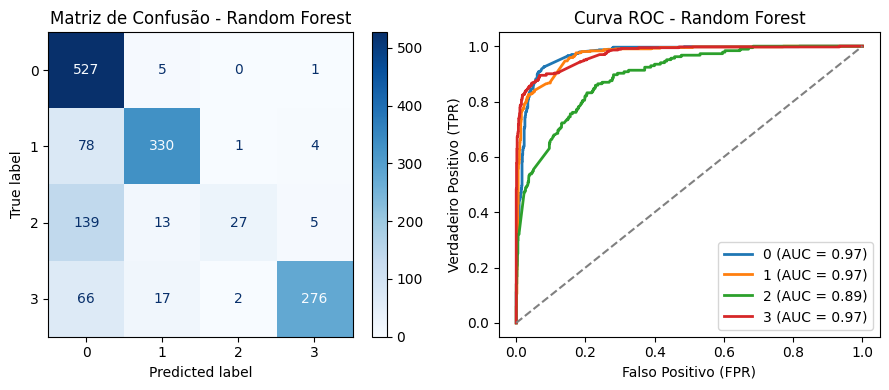


Avaliando Modelo: XGBoost
  - Accuracy: 0.8753
  - Precision: 0.8755
  - Recall: 0.8753
  - F1 Score: 0.8741


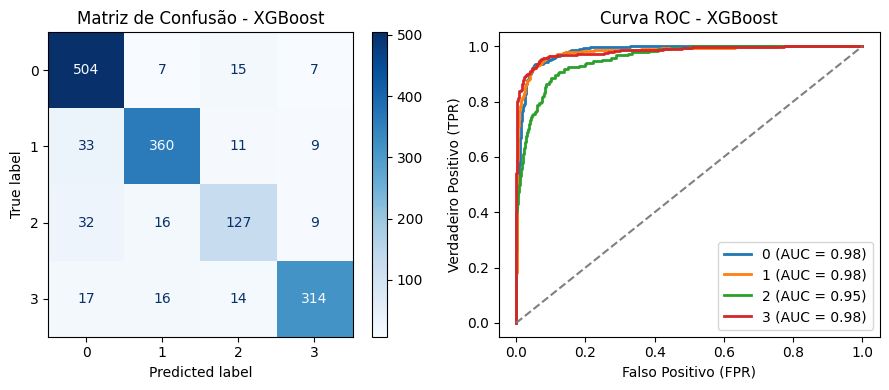


Avaliando Modelo: lighttgbm


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


  - Accuracy: 0.8759
  - Precision: 0.8762
  - Recall: 0.8759
  - F1 Score: 0.8760


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


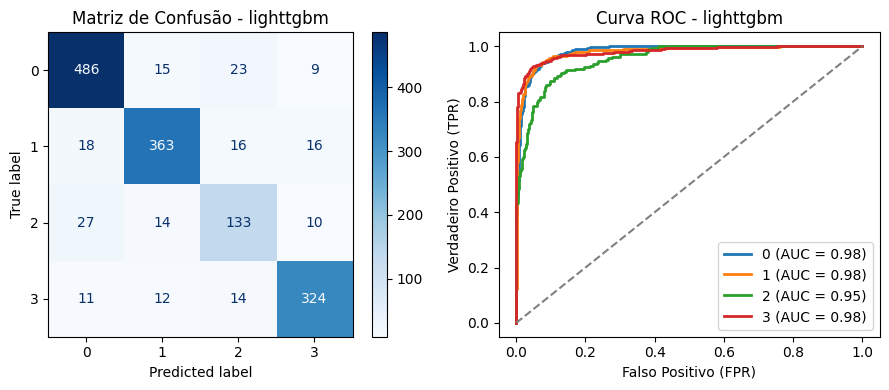


Avaliando Modelo: CATBoost
  - Accuracy: 0.8444
  - Precision: 0.8568
  - Recall: 0.8444
  - F1 Score: 0.8479


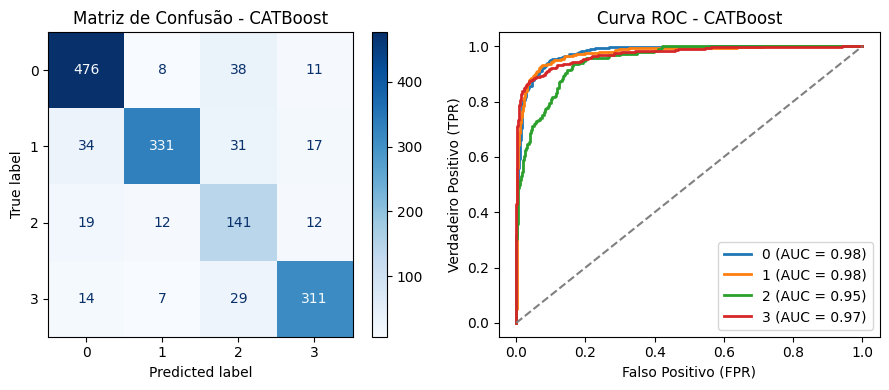

In [ ]:
# Treinar e avaliar os modelos
for name, model in models.items():
    print(f"\nAvaliando Modelo: {name}")

    # Criar pipeline
    pipeline = create_pipeline(model)

    # Treinar o modelo
    pipeline.fit(X_train, y_train)

    # Fazer previsões no conjunto de teste
    y_pred = pipeline.predict(X_test)

    # Métricas de avaliação
    acc = accuracy_score(y_test, y_pred)
    # Changed to 'weighted' to handle multiclass classification
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"  - Accuracy: {acc:.4f}")
    print(f"  - Precision: {prec:.4f}")
    print(f"  - Recall: {rec:.4f}")
    print(f"  - F1 Score: {f1:.4f}")

    # Criar figura com 2 subplots lado a lado
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))

    # Plotar Matriz de Confusão no primeiro subplot
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0], cmap='Blues', values_format='d')
    axs[0].set_title(f"Matriz de Confusão - {name}")

    # Assuming y_prob is the probability predictions (needs to be defined)
    y_prob = pipeline.predict_proba(X_test)

    # Iterate over each class to plot ROC curve for multi-class
    for i, class_name in enumerate(pipeline.classes_):
        fpr, tpr, _ = roc_curve(y_test, y_prob[:, i], pos_label=class_name)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, lw=2, label=f'{class_name} (AUC = {roc_auc:.2f})')

    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_xlabel("Falso Positivo (FPR)")
    axs[1].set_ylabel("Verdadeiro Positivo (TPR)")
    axs[1].set_title(f"Curva ROC - {name}")
    axs[1].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

# **Analises Gráficas**

In [ ]:
analise = pd.read_csv('postagens_reddit_limpo.csv')
analise.head()

,titulo,corpo,upvotes,data_criacao,url,tema
0,panico fabricado cerceamento liberdade,tempo tempo algum caso utilizado tentarem cerc...,3,1.743100e+09,https://i.redd.it/jawsvwgp0are1.jpeg,politica
1,desisti morar argentina realidade,pra argentina faz dez dia parei varias cidades...,5,1.743095e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica
2,argentina governo milei anuncia acordo u bilho...,NaN,7,1.743094e+09,https://www.metropoles.com/negocios/argentina-...,politica
3,esquerda hipocrisia,esquerda falando moral bandido pregando justic...,69,1.743089e+09,https://i.redd.it/vs6b773d29re1.jpeg,politica
4,alguma prova material bozo orquestrou gopi,porra desculpa fazer vcs ai google trampo ta f...,6,1.743074e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica


Utiizei o REN ( Reconhecimento de Entidades Nomeadas) uma tecnica que explora entidades nomeadas nas publicações através de um modelo pré-treinado do SpaCy. Essa  técina irá classificar as entidades em três categorias diferentes Pessoa, Localização e Organização, as entidades que não se encaixam nessas classificações são dadas como diversas. Com esses dados a mais espero poder fazer algumas explorações interessantes sobre os dados.

In [ ]:
!python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_sm")

# Função para extrair entidades nomeadas de um texto
def extrair_entidades(texto):
    if pd.isna(texto):
        return ""  # Retornar string vazia para valores NaN
    if not isinstance(texto, str):
        texto = str(texto) # converte para string
    doc = nlp(texto)
    entidades = [ent.text for ent in doc.ents]  # Extrair o texto das entidades
    return ", ".join(entidades)  # Retorna as entidades como uma string separada por vírgulas

# Aplicar a função de REN na coluna 'titulo' e 'corpo'
analise["entidades_titulo"] = analise["titulo"].apply(extrair_entidades)
analise["entidades_corpo"] = analise["corpo"].apply(extrair_entidades)

# Salvar o dataset com as entidades extraídas
analise.to_csv("postagens_reddit_com_entidades.csv", index=False)

print("Entidades extraídas e salvas em 'postagens_reddit_com_entidades.csv'.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 34.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Entidades extraídas e salvas em 'postagens_reddit_com_entidades.csv'.


In [ ]:
analises = pd.read_csv('postagens_reddit_com_entidades.csv')
analises.head()

,titulo,corpo,upvotes,data_criacao,url,tema,entidades_titulo,entidades_corpo
0,panico fabricado cerceamento liberdade,tempo tempo algum caso utilizado tentarem cerc...,3,1.743100e+09,https://i.redd.it/jawsvwgp0are1.jpeg,politica,NaN,NaN
1,desisti morar argentina realidade,pra argentina faz dez dia parei varias cidades...,5,1.743095e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,desisti morar argentina realidade,"argentina, brasil"
2,argentina governo milei anuncia acordo u bilho...,NaN,7,1.743094e+09,https://www.metropoles.com/negocios/argentina-...,politica,"argentina, fmi",NaN
3,esquerda hipocrisia,esquerda falando moral bandido pregando justic...,69,1.743089e+09,https://i.redd.it/vs6b773d29re1.jpeg,politica,NaN,NaN
4,alguma prova material bozo orquestrou gopi,porra desculpa fazer vcs ai google trampo ta f...,6,1.743074e+09,https://www.reddit.com/r/brasilivre/comments/1...,politica,NaN,NaN


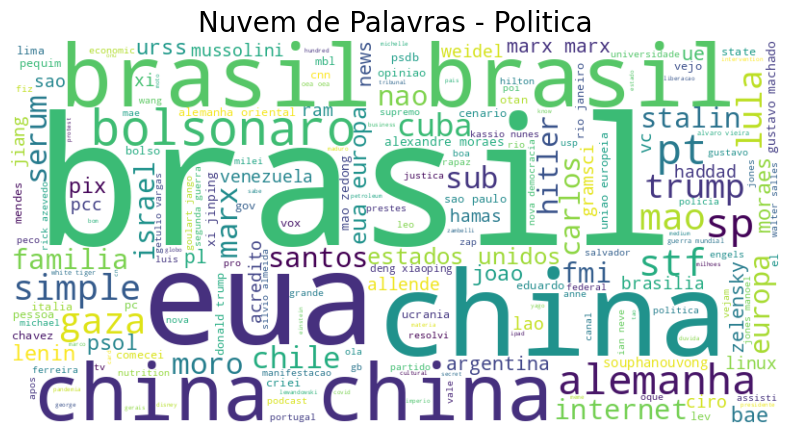

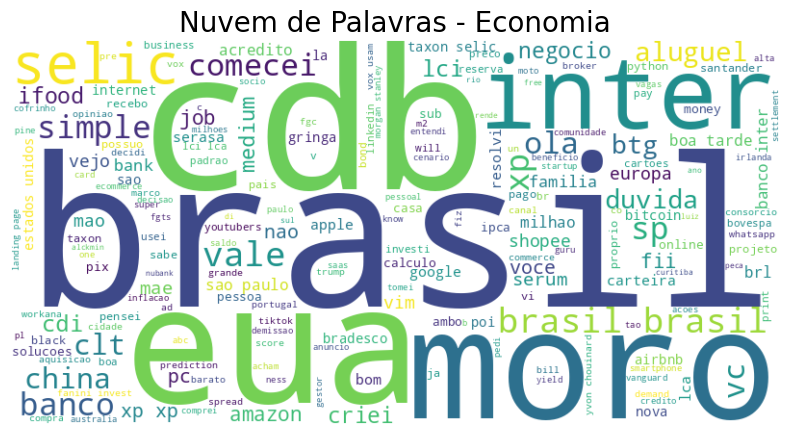

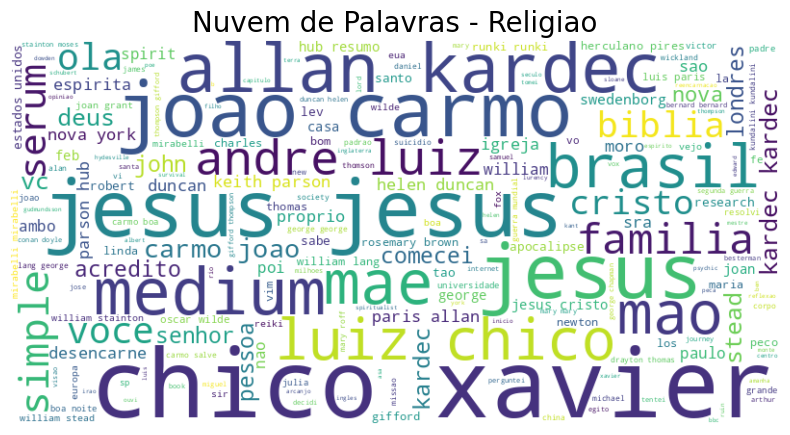

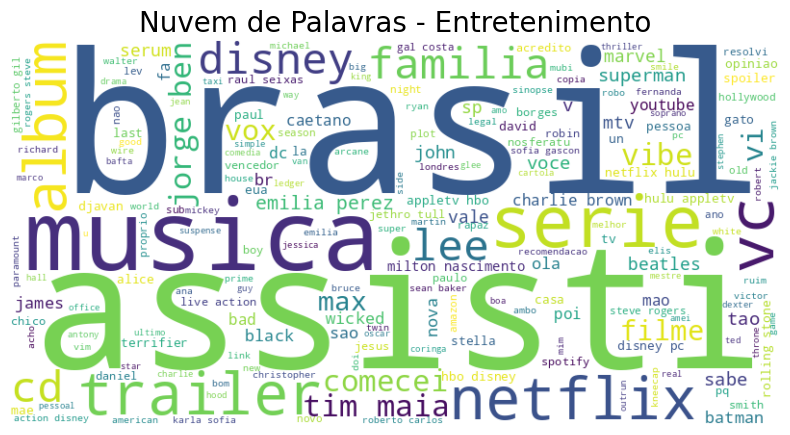

In [ ]:
# Função para extrair entidades nomeadas
def extrair_entidades(texto):
    if pd.isna(texto):
        return []  # Retornar lista vazia para valores NaN
    if not isinstance(texto, str):
        texto = str(texto)  # Convert to string if not already
    doc = nlp(texto)
    entidades = [ent.text for ent in doc.ents]  # Extract named entities
    return entidades

# Aplica a função para extrair as entidades de 'titulo' e 'corpo'
analises["entidades_titulo"] = analises["titulo"].apply(extrair_entidades)
analises["entidades_corpo"] = analises["corpo"].apply(extrair_entidades)

# Gerar nuvem de palavras para cada tema combinando título e corpo
themes = ['politica', 'economia', 'religiao', 'entretenimento']
for theme in themes:
    df_theme = analises[analises['tema'] == theme]

    # Combina entidades do título e corpo
    entidades_theme = []
    for _, row in df_theme.iterrows():
        entidades_theme.extend(row["entidades_titulo"])
        entidades_theme.extend(row["entidades_corpo"])

    # Verificar se há entidades para o tema
    if not entidades_theme:
        print(f"No entities found for theme: {theme.capitalize()}. Skipping word cloud generation.")
        continue

    # Gerar a nuvem de palavras para cada tema
    nuvem_theme = WordCloud(width=800, height=400, background_color='white').generate(' '.join(entidades_theme))

    plt.figure(figsize=(10, 5))
    plt.imshow(nuvem_theme, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Nuvem de Palavras - {theme.capitalize()}", fontsize=20)
    plt.show()

In [ ]:
from collections import defaultdict

def analisar_entidades_multitemas(analises):
    # Dicionário para armazenar em quais temas cada entidade aparece
    entidades_por_tema = defaultdict(set)

    # Iterar sobre as linhas do DataFrame
    for _, row in analises.iterrows():
        tema = row['tema']
        for entidade in row['entidades_titulo'] + row['entidades_corpo']:
            entidades_por_tema[entidade].add(tema)

    # Identificar entidades que aparecem em mais de dois temas
    entidades_multitemas = {entidade: temas for entidade, temas in entidades_por_tema.items() if len(temas) > 2}

    return entidades_multitemas

# Chamar a função e exibir os resultados
entidades_multitemas = analisar_entidades_multitemas(analises)

# Exibir as entidades que aparecem em mais de dois temas
if entidades_multitemas:
    print("Entidades que aparecem em mais de dois temas:")
    for entidade, temas in entidades_multitemas.items():
        print(f"Entidade: {entidade}, Temas: {', '.join(temas)}")
else:
    print("Nenhuma entidade aparece em mais de dois temas.")

Entidades que aparecem em mais de dois temas:
Entidade: brasil, Temas: politica, religiao, economia, entretenimento
Entidade: pl, Temas: politica, religiao, economia, entretenimento
Entidade: bolsonaro, Temas: politica, economia, entretenimento
Entidade: sp, Temas: politica, religiao, economia, entretenimento
Entidade: medium, Temas: politica, religiao, economia
Entidade: eua, Temas: politica, religiao, economia, entretenimento
Entidade: vejo, Temas: politica, religiao, economia, entretenimento
Entidade: alemanha, Temas: politica, religiao, economia, entretenimento
Entidade: portugal, Temas: politica, economia, entretenimento
Entidade: vc, Temas: politica, religiao, economia, entretenimento
Entidade: acredito, Temas: politica, religiao, economia, entretenimento
Entidade: disney, Temas: politica, religiao, entretenimento
Entidade: inglaterra, Temas: politica, religiao, economia
Entidade: sa, Temas: politica, religiao, economia, entretenimento
Entidade: pc, Temas: politica, economia, ent

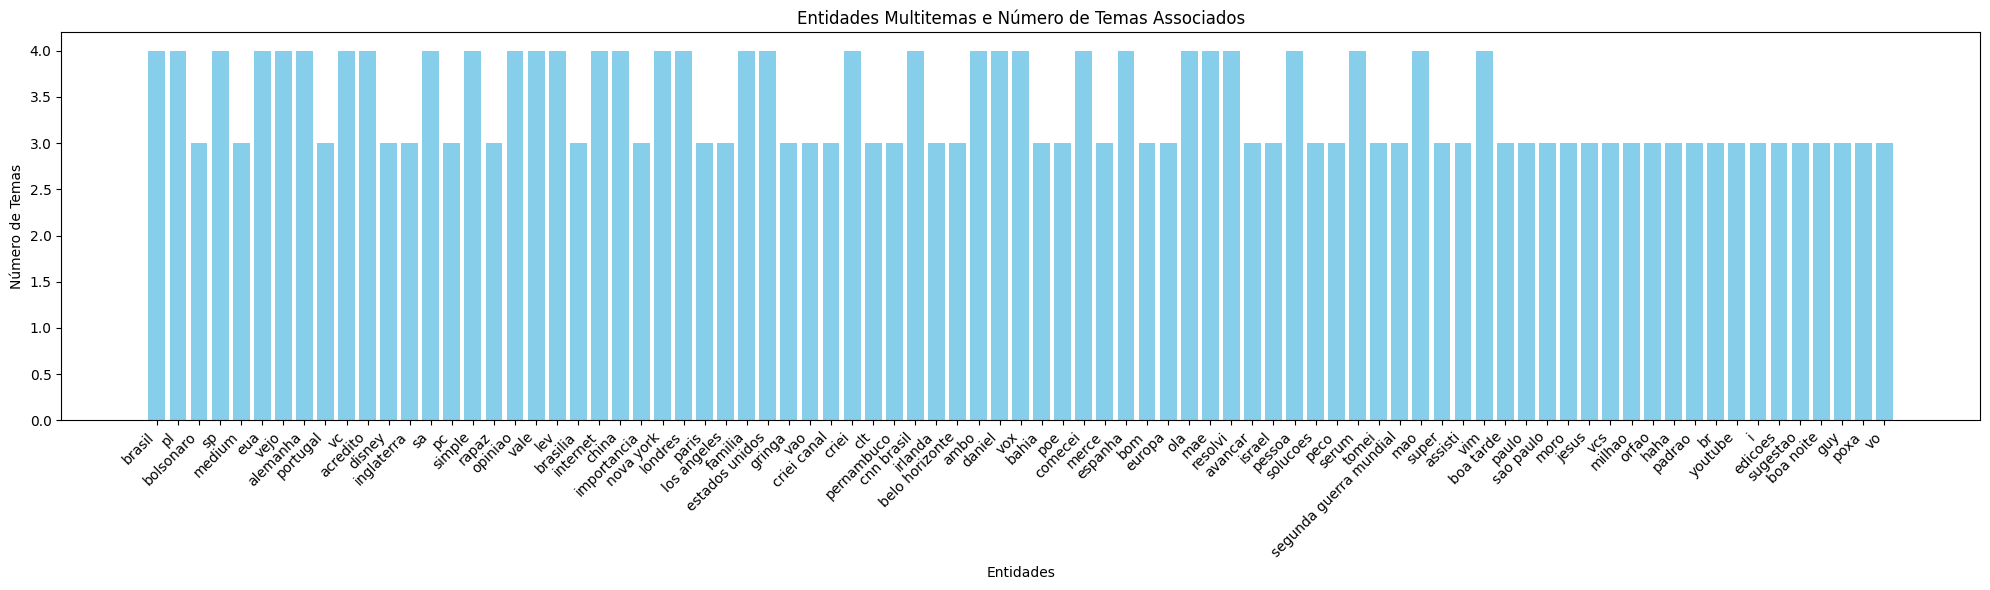

In [ ]:
# Dados para o gráfico
entidades = list(entidades_multitemas.keys())
numero_temas = [len(temas) for temas in entidades_multitemas.values()]

# Criar gráfico de barras
plt.figure(figsize=(20, 6))
plt.bar(entidades, numero_temas, color='skyblue')
plt.xlabel('Entidades')
plt.ylabel('Número de Temas')
plt.title('Entidades Multitemas e Número de Temas Associados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Exibir o gráfico
plt.show()


In [ ]:
from collections import defaultdict

def transformar_multitemas_para_frequencias(entidades_multitemas):
    # Criar um dicionário para armazenar o total por tema
    frequencia_entidades_tema = defaultdict(Counter)

    # Iterar pelas entidades e seus temas
    for entidade, temas in entidades_multitemas.items():
        for tema in temas:
            frequencia_entidades_tema[tema][entidade] += 1

    return frequencia_entidades_tema

def calcular_total_entidades_por_tema(frequencia_entidades_tema):
    # Dicionário para armazenar o total de entidades por tema
    total_entidades_por_tema = {}

    # Iterar sobre os temas e calcular a soma das frequências
    for tema, entidades_frequencia in frequencia_entidades_tema.items():
        total_entidades_por_tema[tema] = sum(entidades_frequencia.values())

    return total_entidades_por_tema


# Transformar entidades_multitemas em frequencia_entidades_tema
frequencia_entidades_tema = transformar_multitemas_para_frequencias(entidades_multitemas)

# Agora usar a função calcular_total_entidades_por_tema
total_entidades = calcular_total_entidades_por_tema(frequencia_entidades_tema)

# Exibir os resultados
print("Total de Entidades por Tema:")
for tema, total in total_entidades.items():
    print(f"Tema: {tema}, Total de Entidades: {total}")


Total de Entidades por Tema:
Tema: politica, Total de Entidades: 69
Tema: religiao, Total de Entidades: 76
Tema: economia, Total de Entidades: 72
Tema: entretenimento, Total de Entidades: 65


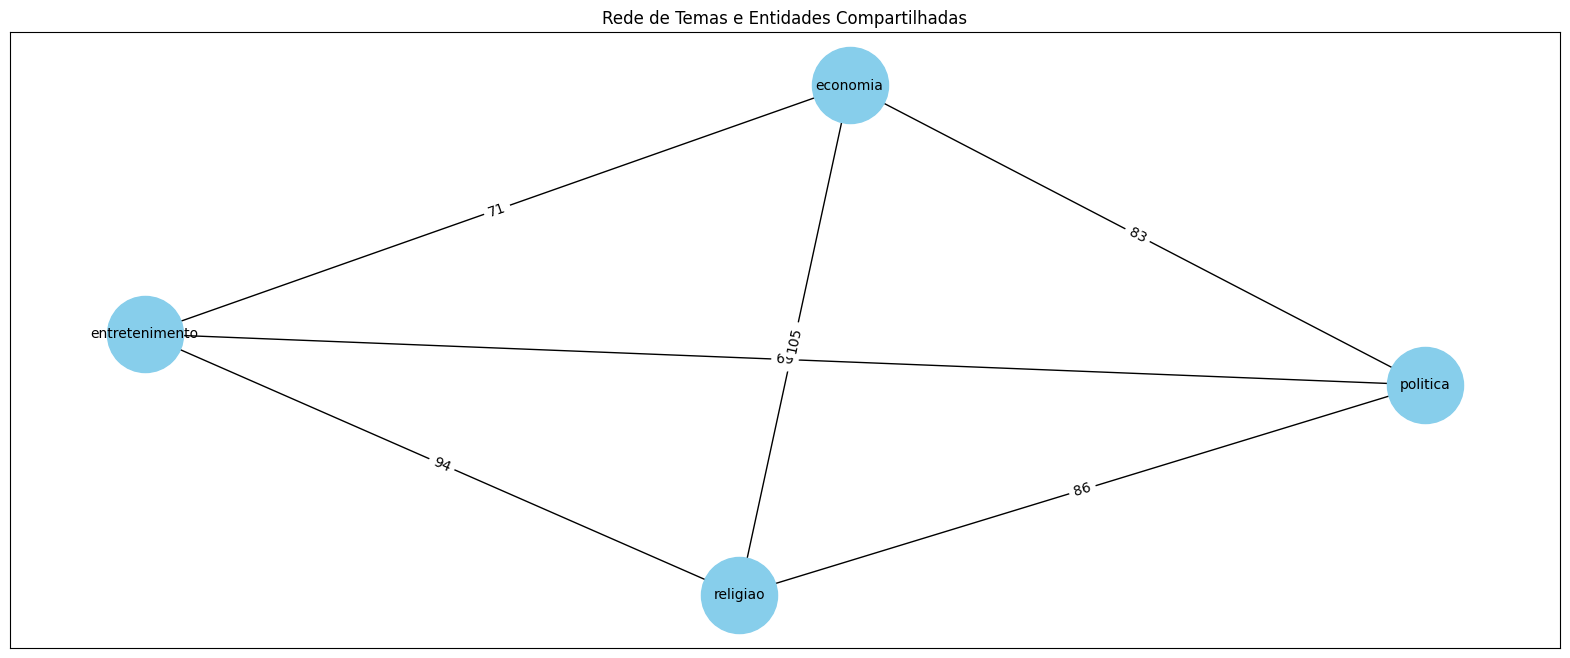

In [ ]:
from itertools import combinations  # Import the combinations function

import networkx as nx

# Criar grafo
grafo = nx.Graph()

# Adicionar nós e arestas
for tema1, tema2 in combinations(matriz_temas.columns, 2):
    peso = matriz_temas.loc[tema1, tema2]
    if peso > 0:
        grafo.add_edge(tema1, tema2, weight=peso)

# Desenhar grafo
pos = nx.spring_layout(grafo)
plt.figure(figsize=(20, 8))
nx.draw_networkx(grafo, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(grafo, 'weight')
nx.draw_networkx_edge_labels(grafo, pos, edge_labels=labels)
plt.title("Rede de Temas e Entidades Compartilhadas")
plt.show()

In [ ]:
from collections import Counter

def calcular_frequencia_entidades_por_tema(analises):
    # Dicionário para armazenar as frequências de cada entidade por tema
    frequencia_entidades_tema = {}

    # Iterar sobre os temas e entidades no DataFrame
    for _, row in analises.iterrows():
        tema = row['tema']
        for entidade in row['entidades_titulo'] + row['entidades_corpo']:
            if tema not in frequencia_entidades_tema:
                frequencia_entidades_tema[tema] = Counter()
            frequencia_entidades_tema[tema][entidade] += 1

    # Retornar os dados de frequência
    return frequencia_entidades_tema

# Chamar a função
frequencia_entidades = calcular_frequencia_entidades_por_tema(analises)

# Transformar em DataFrame para visualização
df_frequencia = pd.DataFrame.from_dict(frequencia_entidades, orient='index').fillna(0)
print("Frequência Absoluta por Tema:")
print(df_frequencia)


Frequência Absoluta por Tema:
                desisti morar argentina realidade  argentina  brasil  fmi  \
politica                                      1.0        5.0     176  7.0   
economia                                      0.0        1.0     152  0.0   
religiao                                      0.0        0.0      48  0.0   
entretenimento                                0.0        0.0      76  0.0   

                lembrete  abraco mbl  valdemar costa neto presidente  pl  \
politica             1.0         1.0                             1.0   6   
economia             0.0         0.0                             0.0   3   
religiao             0.0         0.0                             0.0   1   
entretenimento       0.0         0.0                             0.0   1   

                tao bom barato  little bit of confusion  ...  \
politica                   1.0                      1.0  ...   
economia                   0.0                      0.0  ...   
religiao   

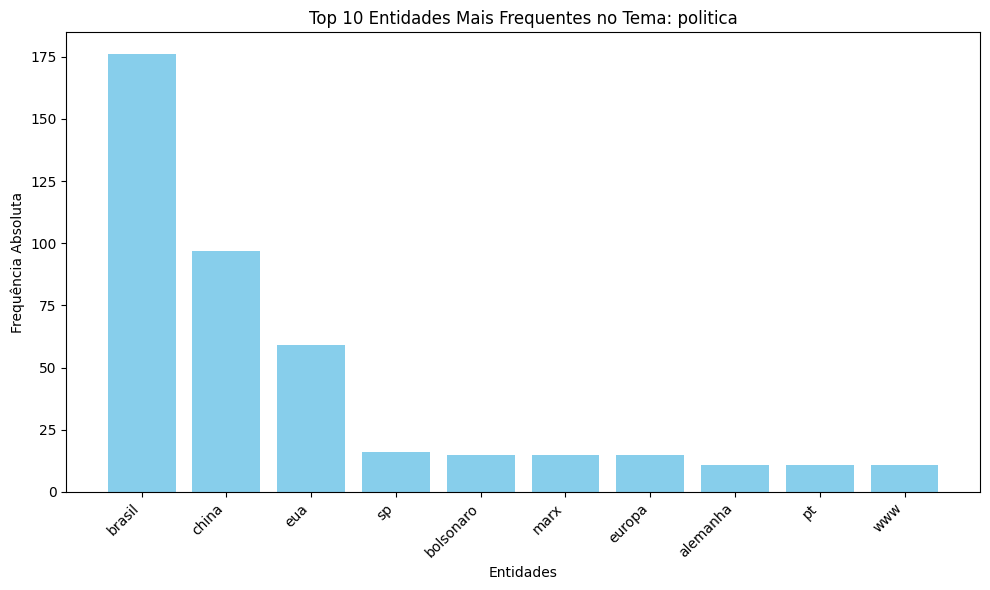

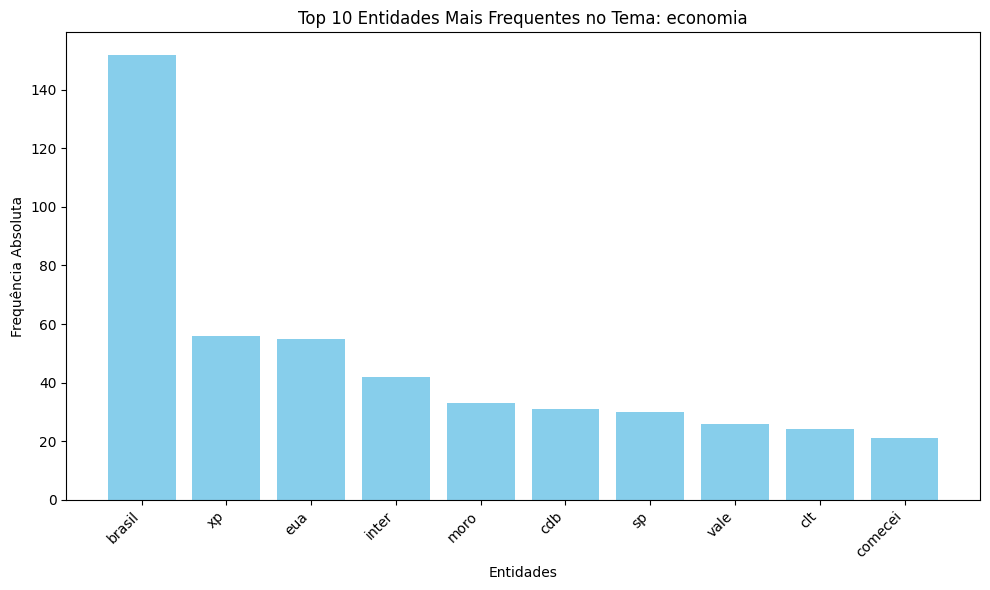

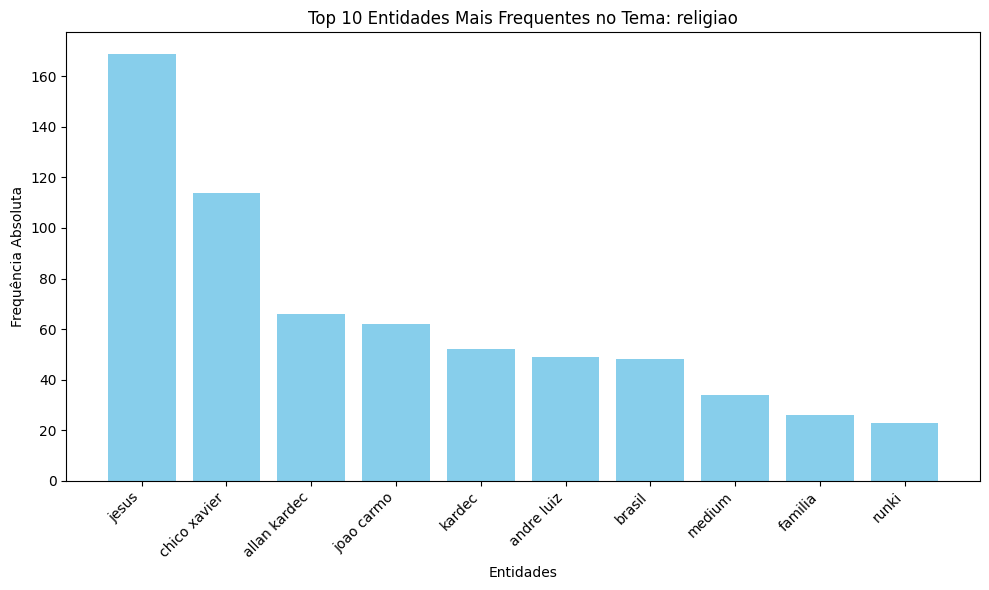

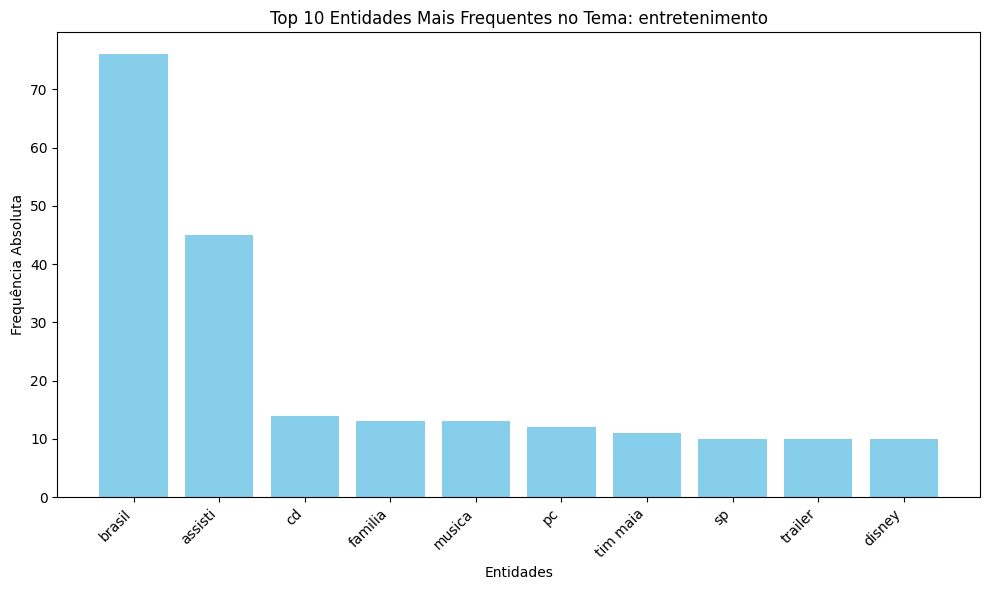

In [ ]:
def gerar_graficos_para_todos_os_temas(frequencia_entidades):
    for tema, frequencias_tema in frequencia_entidades.items():
        # Obter as 10 entidades mais frequentes para o tema atual
        top_10_entidades = Counter(frequencias_tema).most_common(10)

        # Separar os dados em duas listas para o gráfico
        entidades, frequencias = zip(*top_10_entidades)

        # Criar gráfico de barras
        plt.figure(figsize=(10, 6))
        plt.bar(entidades, frequencias, color='skyblue')
        plt.xlabel('Entidades')
        plt.ylabel('Frequência Absoluta')
        plt.title(f'Top 10 Entidades Mais Frequentes no Tema: {tema}')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        # Exibir o gráfico
        plt.show()

# Chamar a função para gerar gráficos
gerar_graficos_para_todos_os_temas(frequencia_entidades)


## **Análise de Sentimentos**

In [ ]:
import nltk
nltk.download('vader_lexicon')

from nltk.sentiment import SentimentIntensityAnalyzer

# Inicializar o analisador de sentimentos
sia = SentimentIntensityAnalyzer()

def analisar_sentimentos_por_tema(analises):
    """
    Roda a análise de sentimentos VADER sobre todas as publicações no dataset 'analises'.

    Args:
        analises (DataFrame): Um DataFrame com colunas 'tema', 'titulo' e 'corpo'.

    Returns:
        DataFrame: Um novo DataFrame com as pontuações de sentimentos (positivo, neutro, negativo, composto).
    """
    # Garantir que o DataFrame original não seja alterado
    analises = analises.copy()

    # Criar uma nova coluna 'texto' combinando 'titulo' e 'corpo'
    analises['texto'] = analises['titulo'] + ' ' + analises['corpo']

    # Converter a coluna 'texto' para string, tratando possíveis floats
    analises['texto'] = analises['texto'].astype(str)

    # Aplicar o VADER sobre cada texto no DataFrame
    analises['sentimentos'] = analises['texto'].apply(sia.polarity_scores)

    # Separar os campos de sentimentos (positivo, neutro, negativo, composto)
    analises['positivo'] = analises['sentimentos'].apply(lambda x: x['pos'])
    analises['neutro'] = analises['sentimentos'].apply(lambda x: x['neu'])
    analises['negativo'] = analises['sentimentos'].apply(lambda x: x['neg'])
    analises['composto'] = analises['sentimentos'].apply(lambda x: x['compound'])

    # Excluir a coluna intermediária 'sentimentos' se não for necessária
    analises = analises.drop(columns=['sentimentos'])

    return analises

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
# Rodar a análise de sentimentos
analises_com_sentimentos = analisar_sentimentos_por_tema(analises)

# Visualizar os primeiros resultados
print(analises_com_sentimentos.head())


                                              titulo  \
0             panico fabricado cerceamento liberdade   
1                  desisti morar argentina realidade   
2  argentina governo milei anuncia acordo u bilho...   
3                                esquerda hipocrisia   
4         alguma prova material bozo orquestrou gopi   

                                               corpo  upvotes  data_criacao  \
0  tempo tempo algum caso utilizado tentarem cerc...        3  1.743100e+09   
1  pra argentina faz dez dia parei varias cidades...        5  1.743095e+09   
2                                                NaN        7  1.743094e+09   
3  esquerda falando moral bandido pregando justic...       69  1.743089e+09   
4  porra desculpa fazer vcs ai google trampo ta f...        6  1.743074e+09   

                                                 url      tema  \
0               https://i.redd.it/jawsvwgp0are1.jpeg  politica   
1  https://www.reddit.com/r/brasilivre/comments/1...  po

In [ ]:
# Calcular a média dos sentimentos por tema
resumo_sentimentos = analises_com_sentimentos.groupby('tema')[['positivo', 'neutro', 'negativo', 'composto']].mean()
print(resumo_sentimentos)


                positivo    neutro  negativo  composto
tema                                                  
economia        0.015556  0.980396  0.004052  0.088543
entretenimento  0.025466  0.956087  0.018449  0.040104
politica        0.012985  0.975737  0.011288  0.031464
religiao        0.016972  0.976167  0.006859  0.147219


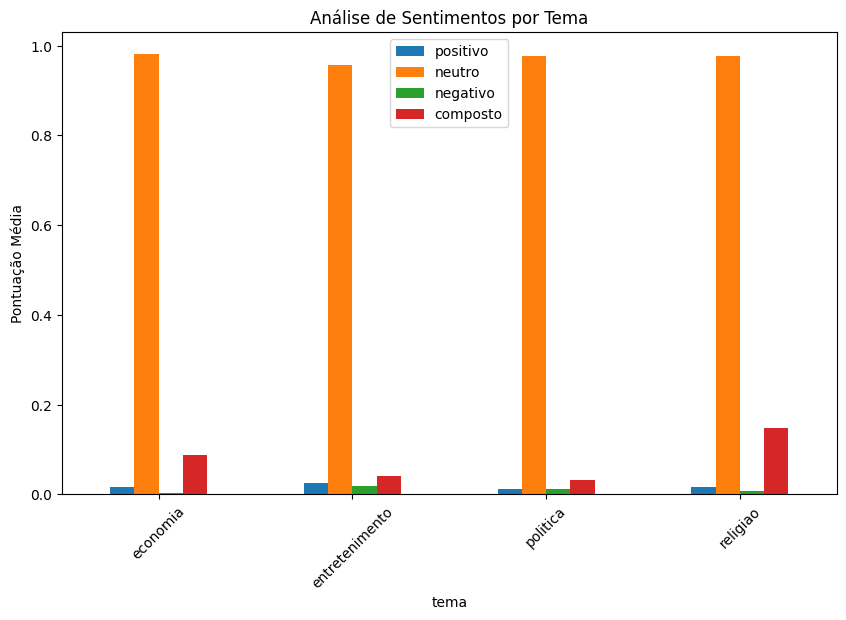

In [ ]:
# Plotar as médias dos sentimentos por tema
resumo_sentimentos.plot(kind='bar', figsize=(10, 6), title='Análise de Sentimentos por Tema', ylabel='Pontuação Média')
plt.xticks(rotation=45)
plt.show()